# 1. Data

In [1]:
import pandas as pd
import numpy as np
import ijson
from tqdm.notebook import tqdm
import networkx as nx
import community  # Louvain method
import matplotlib.pyplot as plt
import ast
import itertools

converting the Json file to CSV and then dataframe keeping only the most important information for memory issues.\
font: https://www.kaggle.com/code/devintheai/citation-network-eda
We adapted the code found in this link to extract all the information, including the autors' information.

In [2]:
"""
PAPERS = []

with open("./dblp.v12.json", "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            # joining all authors in a list
            paper['authors'] = [auth for auth in authors]
        
        year = element.get('year')
        if year:
            paper['year']= year
        else:
            paper['year']= np.nan
        
        n_citation= element.get('n_citation')
        if n_citation:
             paper['n_citation']= element['n_citation']
        else:
            paper['n_citation']= 0
        
        doc_type= element.get('doc_type') 
        if doc_type:
            paper['doc_type']= element['doc_type']
        else:
            paper['doc_type']= np.nan      

        references= element.get('references')
        if references:
            paper['reference_count']= len(references)
            # joining all refs id in a `;` seperated string  
            paper['references']= ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count']= np.nan 
            paper['references']= np.nan
        
        doi = element.get('doi')
        if doi:
            paper['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper['doi']= np.nan               
        
        
        PAPERS.append(paper)
"""

'\nPAPERS = []\n\nwith open("./dblp.v12.json", "rb") as f:\n    for i, element in tqdm(enumerate(ijson.items(f, "item"))):\n        paper = {}\n        paper[\'id\'] = element[\'id\']\n        paper[\'title\'] = element[\'title\']\n\n        authors = element.get(\'authors\')\n        if authors:\n            paper[\'num_authors\'] = len(authors)\n            # joining all authors in a list\n            paper[\'authors\'] = [auth for auth in authors]\n        \n        year = element.get(\'year\')\n        if year:\n            paper[\'year\']= year\n        else:\n            paper[\'year\']= np.nan\n        \n        n_citation= element.get(\'n_citation\')\n        if n_citation:\n             paper[\'n_citation\']= element[\'n_citation\']\n        else:\n            paper[\'n_citation\']= 0\n        \n        doc_type= element.get(\'doc_type\') \n        if doc_type:\n            paper[\'doc_type\']= element[\'doc_type\']\n        else:\n            paper[\'doc_type\']= np.nan      

Now we'll convert the information extracted in a dataframe and save them in a csv file, called "citations_network.csv"

In [3]:
"""
data = pd.DataFrame(PAPERS)
data.head()
data.to_csv("citations_network.csv", index=False)
"""

'\ndata = pd.DataFrame(PAPERS)\ndata.head()\ndata.to_csv("citations_network.csv", index=False)\n'

our new dataset to create our subgraph for our investigation. Considering only the most connected componet of the graph.

In [4]:
df = pd.read_csv('citations_network.csv')

/var/folders/d6/sz5pbmks2gs12gkp2yzr1gl00000gn/T/ipykernel_79884/1613949839.py:1: DtypeWarning: Columns (0,2,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('citations_network.csv')


In [5]:
df.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,1091,Preliminary Design of a Network Protocol Learn...,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,Conference,2.0,2005687710;2018037215,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,Journal,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,Conference,15.0,1535888970;1992876689;1993710814;2035653341;20...,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...",4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,Conference,3.0,1560724230;1986968751;2156909104,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,Conference,NaN,NaN,NaN


In [6]:
df.shape

(4894402, 10)

## Data pre-processing
1. identify the top **10,000** papers with the highest number of citations
   
We just sorted the entire dataset in descending order according to the number of citation of each paper, and kept the first 10,000 rows.


In [7]:
# Convert 'n_citation' column to numeric type if it contains mixed data types
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

# Sort the DataFrame by 'n_citation' column in descending order
df_sorted = df.sort_values(by='n_citation', ascending=False)

# Take the top 10,000 rows after sorting and reset the index
df_s = df_sorted.head(10000).reset_index(drop=True)

In [8]:
# converting the authors' information from string to list
df_s['authors'] = df_s['authors'].apply(lambda row: ast.literal_eval(row))

In [9]:
df_s.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,2041404167,The Mathematical Theory of Communication,1.0,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327.0,Book,NaN,NaN,NaN
1,1639032689,"Genetic algorithms in search, optimization, an...",1.0,"[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175.0,Book,NaN,NaN,NaN
2,2912565176,Fuzzy sets,1.0,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437.0,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,1.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541.0,Journal,33.0,19720318;1541642243;1560959218;1676552347;1681...,https://doi.org/10.1023/B:VISI.0000029664.9961...
4,2911964244,Random Forests,1.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741.0,NaN,11.0,1507255258;1580948147;1605688901;1975846642;20...,https://doi.org/10.1023/A:1010933404324


### Citation graph
- Representation of the paper's *citation relationships*, where each node is a paper and the edge between two nodes is present only if the starting node cites the second node.
- Unweighted
- Directed

2. The **nodes** of the graph

In [10]:
# the nodes of the graph will be all the unique rows that are present in the dataset

# creating the directed graph
cit_G = nx.DiGraph(name = 'Citation Graph')

# adding the nodes and the attributes (the columns of the dataset)
for i, pap in df_s.iterrows():
    node = pap['id']
    attributes = {}
    for el in list(df_s.columns)[1:]:
        attributes[el] = pap[el]
    cit_G.add_node(node, **attributes)

print(f'number of nodes in the Citation Graph: {len(cit_G.nodes())}')

number of nodes in the Citation Graph: 10000


3. The **edges** of the graph

The edges are defined by simply connecting each edge with all the paper's ids that specific paper cites; those can be found in the feature *references*.\
Those ids have been stored in a string separated by the ";", so what we'll do is to create a dictionary that is structured in the following way:
```python
result_dict = {node_A : [node_B, node_c...], node_B : [node_i, ... ]}
```
where the key is the starting node and its value is a list of all the reachable nodes from it.

In [11]:
# the edges are all the papers' ids in the 'references' column
def citation_dict(row, d={}):
    if pd.notnull(row['references']):
        d[row['id']] = [int(cit) for cit in row['references'].split(';')]
    return d

# apply the function to each row in the DataFrame to save the citation's relationship in a dictionary
result_dict = {}
for idx, row in df_s.iterrows():
    result_dict = citation_dict(row, result_dict)

Now we'll use the dictionary ```result_dict``` to create the directed edges in the graph

In [12]:
for start in result_dict.keys():
    for end in result_dict[start]:
        cit_G.add_edge(start, end)

In [13]:
print(f'number of nodes in the Citation Graph considering all the citations: {len(cit_G.nodes())}')

number of nodes in the Citation Graph considering all the citations: 104469


If we're interested in a rapresentatin of a portion of the graph (a subgraph of about 20 nodes, for the sake of a clearer view)

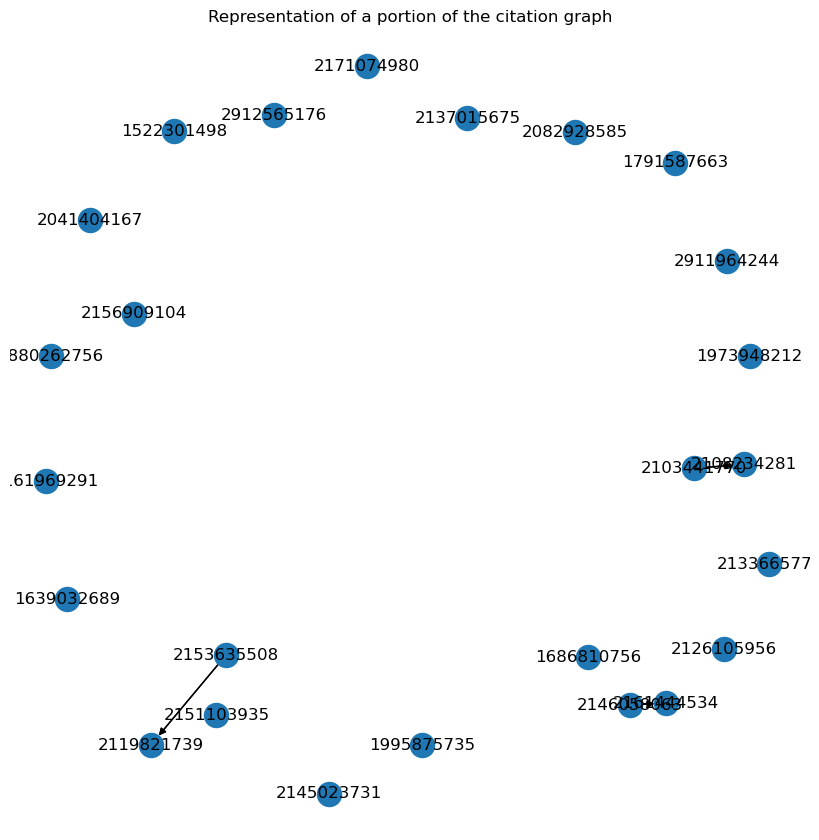

In [14]:
# creating a subgraph of nodes
subgraph = cit_G.subgraph(list(cit_G.nodes())[:25])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(8,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

### Collaboration graph
- Represents the *collaborations of the paper's authors*, where each node is an author and the undirected edge between two nodes represents the fact that those two authors have collaborated in a research paper. 
- Weighted: the weight will be the the number of research papers the couple of authors have worked on together.
- Undirected

2. The **nodes** of the graph
3. The **edges** of the graph: undirected and weighted

In [15]:
collab_G = nx.Graph(name = 'Collaboration Graph') 

In [16]:
tqdm.pandas()

# dictionary to count the collaborations between each author's couple 
author_collaborations = {}
for authors_list in df_s['authors']:
    author_ids = [author['id'] for author in authors_list]  # extract the author's id for each paper
    author_combinations = itertools.combinations(author_ids, 2) # find all the possible combinations of the authors for the current paper
    
    for pair in author_combinations: # keep the count of the collaborations for each author's couple
        pair = tuple(sorted(pair))  # sort the ids to keep coherence in the couple
        if pair not in author_collaborations.keys():
            author_collaborations[pair] = 1
        else:
            author_collaborations[pair] += 1

# now create the graph with the author's couple of edges, networkX will automatically create the nodes if not present already

for authors, num_collab in author_collaborations.items():
    author1, author2 = authors
    collab_G.add_edge(author1, author2, weight=num_collab) # create the graph with the weighted edges: the number of times each author worked with the other

# now we have to add all the authors that have never collaborated with anyone else  
def apply_record(G, data):
  authors_list = []
  for author in data['authors']:
    authors_list.append(author['id'])
    G.add_node(author['id'], name=author['name'])
    if 'org' in author:
      G.nodes()[author['id']]['org'] = author['org']

df_s.progress_apply(lambda row: apply_record(collab_G, row), axis=1)

print(f'number of nodes in the Collaboration Graph: {len(collab_G.nodes())}')
print(f'number of edges in the Collaboration Graph: {len(collab_G.edges())}')

  0%|          | 0/10000 [00:00<?, ?it/s]

number of nodes in the Collaboration Graph: 21232
number of edges in the Collaboration Graph: 136463


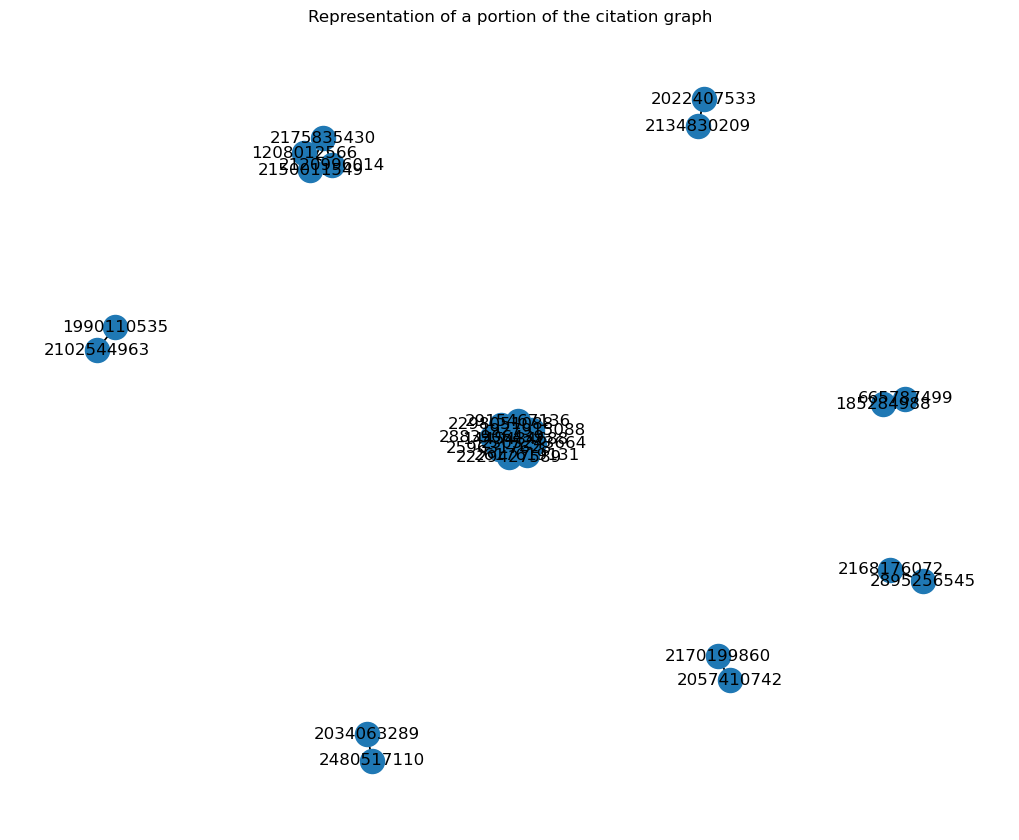

In [17]:
# creating a subgraph of nodes
subgraph = collab_G.subgraph(list(collab_G.nodes())[:25])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(10,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

As a final step, we can save the graphs in a GraphML file

In [18]:
nx.write_graphml(collab_G, "Collaboration_Graph.graphml")

# in order to save the citation graph, we have to remove the author attribute, because is a list and is not supported by GraphML
for node in cit_G.nodes():
    if 'authors' in cit_G.nodes[node]:
        del cit_G.nodes[node]['authors']
nx.write_graphml(cit_G, "Citation_Graph.graphml")

# 2. Controlling system

## 2.1. Backend Implementation

### Functionality 1 - Graph's features

Let's first read graphs from Citation and Collaboration graphs:

In [39]:
def read_graphs():
    citation_graph = nx.read_graphml('./Citation_Graph.graphml')
    collaboration_graph = nx.read_graphml('./Collaboration_Graph.graphml')
    return citation_graph, collaboration_graph

# Read graphs
citation_graph, collaboration_graph = read_graphs()

# This method, creates a subgraph from a given graph with N number of first nodes to consider
def create_subgraph(graph, N):   
    subset_nodes = list(graph.nodes())[:N]  # Selects the first 'N' nodes in the graph
    subgraph = nx.Graph()  # Creates an empty graph object
    subgraph.add_nodes_from(subset_nodes)  # Adds the subset_nodes to the subgraph
    return subgraph

- In the following method, we calculate the number of nodes and edges, deensity, Degree-related values for a given graph including degree distribution, average degree amount, hubs, and a boolean is_dense variable.
 
- For calculatinng the density of the graph we used NetworkX's. A density of 0 means that the number of edges in the graph is close to the minimum number of edges needed for a graph of that size. Consequently, it implies the graph is relatively sparse, with fewer connections between nodes compared to the maximum possible connections.

- For networks like citation networks, sparsity might be natural and not every node paper is connected to every other node.

- **Note:**
    - If the density of the graph is close to 1, it's considered dense.
    - If the density is closer to 0, it's considered sparse.

In [20]:
def graph_features(graph, graph_name):

    # number of nodes and edges:
    number_of_nodes = graph.number_of_nodes()
    number_of_edges = graph.number_of_edges()
    
    # Calculate the density of the graph using NetworkX's 
    density = nx.density(graph)
    
    # Degree histogram returns a list of counts where the index is the degree
    degree_distribution = nx.degree_histogram(graph)

    # Calculate the average degree of the graph
    avg_degree = sum(dict(graph.degree()).values()) / len(graph)

    # Calculate degrees of all nodes
    degrees = dict(graph.degree())
    
    # Calculate the 95th percentile of the degree distribution
    percentile_95 = np.percentile(list(degrees.values()), 95)
    
    # Identify nodes that are hubs (nodes with degrees higher than the 95th percentile)
    hubs = [node for node, degree in degrees.items() if degree > percentile_95]
    

    
    # Set a threshold for determining if the graph is dense or sparse
    # we assigned 0.0005 to the threshold, to divide citation and collabration graphs 
    # into 2 groups of sparse and dense.
    threshold = 0.0005  # threshold value for density comparison.
    is_dense = False
    
    if density >= threshold:
        is_dense = True
    else:
        is_dense = False

    return number_of_nodes, number_of_edges, degree_distribution, avg_degree, is_dense, hubs

In [22]:
# # Test method-1
# graph_features(citation_graph, "citation")
# graph_features(collaboration_graph, "collaboration")

## Functionality 2 - Nodes' contribution

This function takes a graph and a specific node within that graph as input.
It computes various centrality measures for the specified node in the given graph.

**betweenness centrality:**

We compute the betweenness centrality for all nodes in the graph using NetworkX's betweenness_centrality function. Betweenness Centrality is a metric used in network analysis to identify the importance of a node within a graph based on its centrality in the flow of information between other nodes.

- Betweenness Centrality calculates the shortest paths between all pairs of nodes in a graph.
- For each node 'v' in the graph, it counts the number of these shortest paths that pass through 'v'.
- Nodes with higher betweenness centrality scores are considered more important in the transfer of information within the network.
- The usecase for betweenness centrality is to Identify critical nodes and to Understand nodes that act as bridges.

**PageRank:**

It measures the importance of a node based on the idea of "importance by association." 

- PageRank considers a node important if it is pointed to by other important nodes.
- It assumes a web-like structure where nodes are web pages, and edges are hyperlinks between pages.
- PageRank includes a damping factor (usually set to around 0.85) to model the probability that a user randomly jumps from one page to another instead of following links.

If we want to apply PageRank on our system, 

- Initially, all nodes are assigned an equal probability or "importance score."
- The algorithm iterates through the nodes' connections, adjusting their scores based on incoming links from other nodes.
- A node's importance is distributed among the nodes it points to, divided by the number of outbound links.
- The process continues by updating node importance based on the importance of the nodes pointing to them. till the time that the importance scores no longer change significantly between iterations.

**Closeness Centrality:**

It assesses how quickly a node can interact with other nodes in the network, considering the shortest paths between the node and all other nodes.

- Proximity to Others: It evaluates how quickly a node can reach all other nodes in the network.
- Shortest Paths: Closeness Centrality is based on the sum of the shortest path lengths from a node to all other nodes in the network.
- How to calculate Closeness?
    1) the shortest paths to all other nodes should be computed.
    2) Sum up these path lengths from the node to all other nodes.
    3) The reciprocal of this sum is taken to normalize the value, making nodes with lower total path lengths (closer to all other nodes) have higher closeness centrality scores.
 
**Degree Centrality**

It determines the importance or centrality of a node within a network. It's based on the number of links (edges) connected to a node.

- Nodes with higher degree centrality are often considered more influential or important within the network due to their numerous connections.
- High degree nodes are often hubs in the network, serving as central points of connection or information exchange.

In [24]:
def nodes_contribution(graph, node, graph_name):    
    # Calculate Betweenness Centrality for all nodes
    betweenness = nx.betweenness_centrality(graph)
    
    # Get Betweenness Centrality for the specified node
    node_betweenness = betweenness.get(node)
    
    # Calculate PageRank centrality for all nodes
    pagerank = nx.pagerank(graph)
    
    # Get PageRank centrality for the specified node
    node_pagerank = pagerank.get(node)
    
    # Calculate Closeness Centrality for all nodes
    closeness = nx.closeness_centrality(graph)
    
    # Get Closeness Centrality for the specified node
    node_closeness = closeness.get(node)

    # Calculate Degree Centrality for all nodes
    degree_centrality = nx.degree_centrality(graph)
    
    # Get Degree Centrality for the specified node
    node_degree_centrality = degree_centrality.get(node)
    
    return node_betweenness, node_pagerank, node_closeness, node_degree_centrality

## Functionality 3 - Shortest ordered walk

below, we tried to find the shortest ordered walk between specified nodes in a graph.

- first, we checked the a_1 and a_n, and then created our own ordered nodes.
- Then, we iterate through the list of ordered nodes and find the shortest path between each pair of consecutive nodes using nx.shortest_path.
- We Appended all intermediate nodes from each shortest path (excluding the last node) to the shortest_path list. and finally we added the last a_n node to the shortest path.

In [25]:
def shortest_ordered_walk(graph, authors_a, a_1, a_n):
    # Check if a_1 and a_n are in the graph
    if a_1 not in graph.nodes() or a_n not in graph.nodes():
        return "One or more authors are not present in the graph."

    # Create a list to store the ordered nodes
    ordered_nodes = [a_1] + authors_a + [a_n]

    # Check if the nodes exist in the graph
    for i in range(len(ordered_nodes) - 1):
        if not nx.has_path(graph, ordered_nodes[i], ordered_nodes[i + 1]):
            return "There is no such path."

shortest_path = []  # Initialize an empty list to store the nodes in the shortest path

# Loop through the ordered_nodes list to find shortest paths between consecutive nodes
for i in range(len(ordered_nodes) - 1):
    # Find the shortest path between current node (ordered_nodes[i]) and the next node (ordered_nodes[i + 1])
    path = nx.shortest_path(graph, ordered_nodes[i], ordered_nodes[i + 1])
    # Add the middle nodes from the path (excluding the last node) to the shortest_path list
    shortest_path.extend(path[:-1])
    shortest_path.append(a_n)  # Append the final node a_n

    return shortest_path

## Functionality 4 - Disconnecting Graphs

Here, we find the minimum number of edges that need to be removed from a graph to disconnect two specific authors, author_a and author_b, given a set of top_authors.

- first, we filter the top_authors list to include only those authors that exist as nodes in the given graph.
- We created a copy for the graph in order not to alter the actual graph data.
- we specifuied edges between pairs of top authors (top_authors_data) and create a list edges_to_remove containing those edges.
- Then, we removed those identified edges from the copied graph temp_graph.
- Using NetworkX's edge_connectivity function, we calculate the minimum number of edges (edge_connectivity) that need to be removed from temp_graph to disconnect author_a and author_b.


In [26]:
def min_edges_to_disconnect(graph, author_a, author_b, top_authors):
    # Extract the top authors' data
    top_authors_data = [author for author in top_authors if str(author) in graph.nodes()]

    # Create a copy of the original graph
    temp_graph = graph.copy()

    # Remove edges between top authors
    edges_to_remove = []
    for edge in temp_graph.edges():
        if (edge[0] in top_authors_data and edge[1] in top_authors_data):
            edges_to_remove.append(edge)

    temp_graph.remove_edges_from(edges_to_remove)

    # Calculate edge connectivity between authors A and B
    edge_connectivity = nx.edge_connectivity(temp_graph, author_a, author_b)

    return edge_connectivity

## Functionality 5 - Extracting Communities

Here we create a subgraph based on a subset of nodes, detect communities within this subgraph, calculate the minimum edges needed to be removed for the communities, and check if two specified papers belong to the same community within these detected communities.

In [361]:
def extract_communities(subgraph, paper_1, paper_2):

    subgraph = create_subgraph(graph, 50)

    # Extracts edges within the subset_nodes from the original graph to create the subgraph
    subgraph.add_edges_from(graph.subgraph(subset_nodes).edges())

    # Detect communities using Louvain method
    communities = list(nx.algorithms.community.greedy_modularity_communities(subgraph))

    # Find the minimum number of edges to remove for communities
    num_edges_to_remove = nx.algorithms.community.quality.modularity(subgraph, communities)

    # Check if Paper_1 and Paper_2 belong to the same community
    same_community = any([paper_1 in community and paper_2 in community for community in communities])

    return num_edges_to_remove, communities, same_community, subgraph

## 2.2. Frontend Implementation

### Visualization 1 - Visualize graph features

Here we created a table, representing the desired features of both Citation and Collabration graph.
In the table, we show:

- Number of nodes in the graph
- Number of the edges in the graph
- Density of the graph
- Average degree of the graph
- Whether the network is sparse or dense
- lists the graph's hubs

In [28]:
# Collect information for citation_graph and collaboration_graph
citation_info = graph_features(citation_graph, "citation")
collaboration_info = graph_features(collaboration_graph, "collaboration")

# Create a DataFrame to hold the information
data = {
    'Number of Nodes': [citation_info[0], collaboration_info[0]],
    'Number of Edges': [citation_info[1], collaboration_info[1]],
    'Density': [citation_info[2], collaboration_info[2]],
    'Average Degree': [citation_info[3], collaboration_info[3]],
    'Network Type': ['Dense' if citation_info[4] else 'Sparse', 'Dense' if collaboration_info[4] else 'Sparse'],
    'Top 20 hubs': [citation_info[5][:20], collaboration_info[5][:20]]
}

feature_df = pd.DataFrame(data).T
feature_df = feature_df.rename(columns={0: "Citation", 1:"Collaboration"})
feature_df

# citation_info[5][:20], collaboration_info[5][:20]

,Citation,Collaboration
Number of Nodes,100830,21232
Number of Edges,187811,136463
Density,"[323, 67467, 14061, 5310, 2509, 1459, 846, 622...","[1030, 3231, 3493, 2714, 1860, 1313, 995, 695,..."
Average Degree,3.7253,12.854465
Network Type,Sparse,Dense
Top 20 hubs,"[2041404167, 1639032689, 2912565176, 215110393...","[1445484688, 2104401652, 2435751034, 200741513..."


Here is a plot depicting the distribution of the citations received by papers (Citation graph)

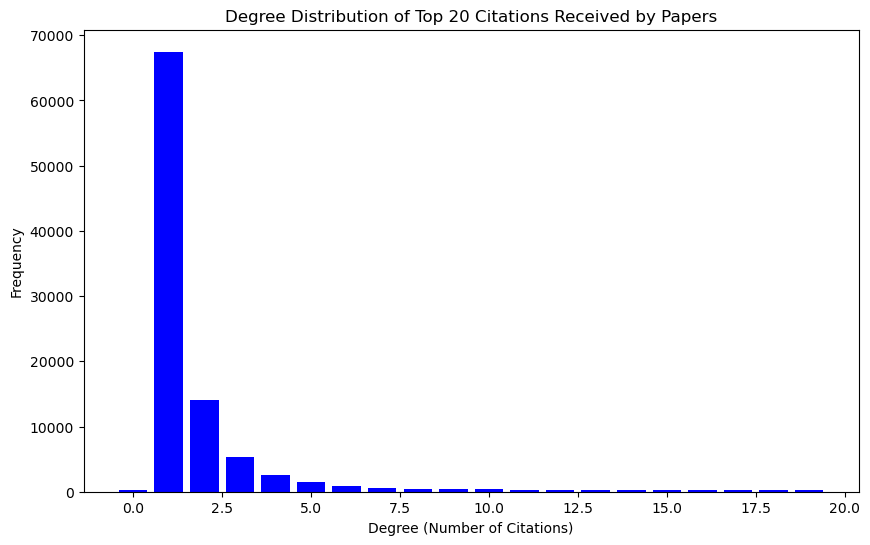

In [38]:
# Plotting top 20 degrees
degree_dist = citation_info[2]  # Accessing degree distribution from graph features

# Get degrees and frequencies for top 20 degrees
degrees = np.arange(0, 20)
top_degree_dist = degree_dist[:20]

plt.figure(figsize=(10, 6))
plt.bar(degrees, top_degree_dist, width=0.8, color='b')

plt.title('Degree Distribution of Top 20 Citations Received by Papers')
plt.xlabel('Degree (Number of Citations)')
plt.ylabel('Frequency')
plt.show()

Here is a plot depicting the distribution of the given citations by papers (Citation graph)

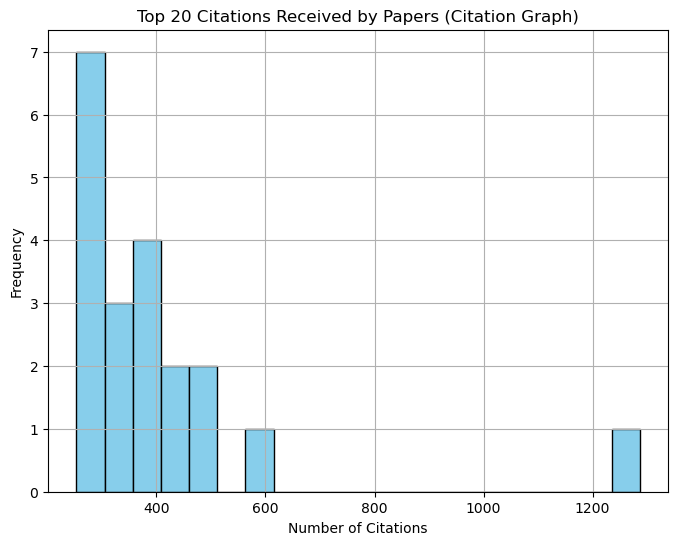

In [30]:
degrees = dict(citation_graph.degree())  # Extract degrees of nodes

# Get the top degrees and their frequencies
sorted_degrees = sorted(degrees.values(), reverse=True)
top_20_degrees = sorted_degrees[:20]

plt.figure(figsize=(8, 6))
plt.hist(top_20_degrees, bins=20, color='skyblue', edgecolor='black')
plt.title('Top 20 Citations Received by Papers (Citation Graph)')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Here is a plot depicting the number of collaborations of the author (Collaboration graph)

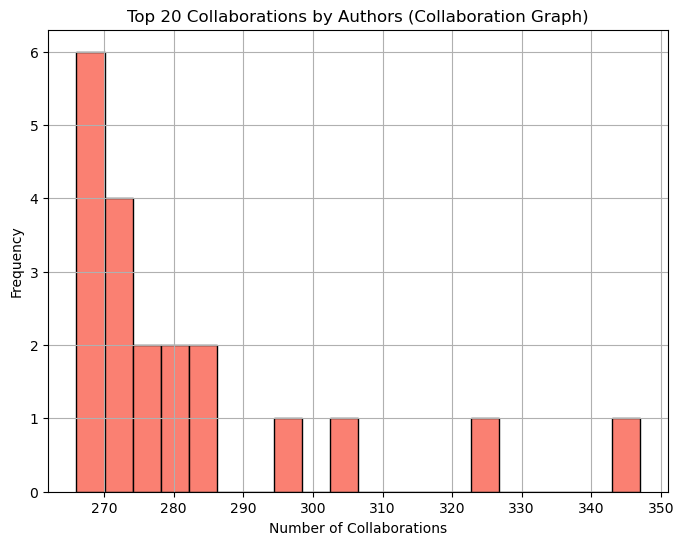

In [31]:
degrees = dict(collaboration_graph.degree())  # Extract degrees of nodes

# Get the top 20 degrees and their frequencies
sorted_degrees = sorted(degrees.values(), reverse=True)
top_20_degrees = sorted_degrees[:20]

plt.figure(figsize=(8, 6))
plt.hist(top_20_degrees, bins=20, color='salmon', edgecolor='black')
plt.title('Top 20 Collaborations by Authors (Collaboration Graph)')
plt.xlabel('Number of Collaborations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Visualization 2 - Visualize the node's contribution

Here, we created a sub graph from the main graphs, to process data easier on local machines.

In [40]:
# Considering top 10000 nodes of both graphs
citation_subgraph = create_subgraph(citation_graph, 10000)
collaboration_subgraph = create_subgraph(collaboration_graph, 10000)

- Here we selected nodes '2076063813' and '2146468246' for citation and collabration graphs respectively.
- you can change the nodes to calculate betweenness, page rank, closeness, and degree centrality of them based on your desire.

In [137]:
citation_contribution_info = nodes_contribution(citation_subgraph, "2076063813", "citation")
collaboration_contribution_info = nodes_contribution(collaboration_subgraph, "2146468246", "Collaboration")

In [138]:
# Create a DataFrame to hold the information
# Here we passed the 2nd node of both graphs to c
contribution_data = {
    'Node': [list(citation_graph.nodes())[1], list(collaboration_graph.nodes())[1]],
    'Node betweenness': [citation_contribution_info[0], collaboration_contribution_info[0]],
    'Node page rank': [citation_contribution_info[1], collaboration_contribution_info[1]],
    'Node closeness': [citation_contribution_info[2], collaboration_contribution_info[2]],
    'Node degree centrality': [citation_contribution_info[3], collaboration_contribution_info[3]]
}

contribution_df = pd.DataFrame(contribution_data).T
contribution_df = contribution_df.rename(columns={0: "Citation", 1: "Collaboration"})
contribution_df

,Citation,Collaboration
Node,1639032689,2102544963
Node betweenness,0.0,0.0
Node pagerank,0.0001,0.0001
Node closeness,0.0,0.0
Node degree centrality,0.0,0.0


### Visualization 3 - Visualize the shortest-ordered route

The code below, helps us to find the most important nodes with the highest number of connected nodes.

In [174]:
# Find all nodes with more than N connected nodes as their neighbors. So 'N' is number of connections
def find_connected_nodes(graph, N, graph_name):
    # Dictionary to store nodes with their neighbors
    nodes_with_neighbors = {}
    # Iterate through nodes and count their neighbors
    for node in list(graph.nodes())[:1000]:
        neighbors = list(graph.neighbors(node))
        if len(neighbors) > N:
            nodes_with_neighbors[node] = neighbors
    
    print(f"Nodes with more than {N} connected neighbors in {graph_name} graph:")
    # print(nodes_with_neighbors)                       # represent all findings
    print(dict(list(nodes_with_neighbors.items())[:5])) # represent only the first item of the array

In [184]:
find_connected_nodes(citation_graph, 8, "Citation")
find_connected_nodes(collaboration_graph, 8, "Collabration")

Nodes with more than 8 connected neighbors in Citation graph:
{'2151103935': ['19720318', '1541642243', '1560959218', '1676552347', '1681491849', '1949116567', '2011891945', '2012778485', '2024668293', '2027089475', '2034501924', '2056313036', '2071866949', '2085207288', '2096077837', '2096600681', '2096680898', '2109863423', '2110826265', '2111308925', '2124087378', '2124386111', '2124404372', '2143539328', '2145713909', '2149646227', '2149814923', '2154422044', '2160835070', '2162601563', '2165497495', '2169351022', '2427881153'], '2911964244': ['1507255258', '1580948147', '1605688901', '1975846642', '2077200366', '2099968818', '2112076978', '2113242816', '2120240539', '2152761983', '2912934387'], '2153635508': ['1510526001', '1543810117', '1556115774', '1568793342', '1621799579', '1775273161', '2011741120', '2036350498', '2047542122', '2056983531', '2087347434', '2096613134', '2097850441', '2100967622', '2104978738', '2110899801', '2115076892', '2115694019', '2119821739', '212435108

Code below, helps us to find connected nodes for a single desired node:

In [316]:
# Choose a single node to find its connected nodes

selected_citation_node = '2911964244'
selected_collabration_node = '2298051088'

# Get nodes connected to the selected node
connected_citation_nodes = list(citation_graph.neighbors(selected_citation_node))
connected_collabration_nodes = list(collaboration_graph.neighbors(selected_collabration_node))

print(f"Nodes connected to node {selected_citation_node} in Citation graph:")
print(connected_citation_nodes)
print(f"Nodes connected to node {selected_collabration_node} in Collaboration graph:")
print(connected_collabration_nodes)

Nodes connected to node 2911964244 in Citation graph:
['1507255258', '1580948147', '1605688901', '1975846642', '2077200366', '2099968818', '2112076978', '2113242816', '2120240539', '2152761983', '2912934387']
Nodes connected to node 2298051088 in Collaboration graph:
['1445484688', '2596317628', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664']


In [327]:
# Usage for NOT connected nodes in collaboration graph:
authors_sequence = ['2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369']
start_author = '1445484688'
end_author = '1958887586'

shortest_ordered_walk_result = shortest_ordered_walk(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest ordered walk:", shortest_ordered_walk_result)

Shortest ordered walk: ['1445484688', '2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369', '1958887586']


In [328]:
# Usage for connected nodes in collaboration graph:
authors_sequence = ['2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369']
start_author = '1445484688'
end_author = '1958887586'

shortest_ordered_walk_result = shortest_ordered_walk(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest ordered walk:\n", shortest_ordered_walk_result)

Shortest ordered walk:
 ['1445484688', '2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369', '1958887586']


**Compare to Dijkstra:**

I asked chatGPT for a different one leveraging another approach in solving the shortest path. It suggested dijkstra algorithm. the results prove that the preevious method is correct.

In [329]:
def shortest_path_dijkstra(graph, authors_sequence, start_author, end_author):
    try:
        shortest_path = [start_author]
        for author in authors_sequence:
            if author not in shortest_path:
                path = nx.shortest_path(graph, source=shortest_path[-1], target=author, method='dijkstra')
                shortest_path.extend(path[1:])
        
        end_path = nx.shortest_path(graph, source=shortest_path[-1], target=end_author, method='dijkstra')
        shortest_path.extend(end_path[1:])
        
        return shortest_path
    except nx.NetworkXNoPath:
        return "There is no such path."

authors_sequence = ['2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369']
start_author = '1445484688'
end_author = '1958887586'

result_dijkstra_sequence = shortest_path_dijkstra(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest path using Dijkstra's algorithm with sequence:\n", result_dijkstra_sequence)


Shortest path using Dijkstra's algorithm with sequence:
 ['1445484688', '2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369', '1958887586']


- The following function illustratse the graph and highlights the edges and nodes in the shortest walk.
- this method, accepts the graph along with the shortest_walk, which is a list representing the nodes that we travel across in the shortest walk.

In [330]:
def plot_shortest_walk(subgraph, shortest_walk):

    pos = nx.spring_layout(subgraph)  # Define the layout for the graph
    plt.figure(figsize=(10, 8))
    
    # Draw the graph - We pass the sub-graph, so all nodes of subgraph will be displayed.
    nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color='skyblue')

    # Highlight nodes and edges in the shortest walk - iterate through the nodes
    for i in range(len(shortest_walk) - 1):
        current_node = shortest_walk[i]
        next_node = shortest_walk[i + 1]

        # Highlight nodes in the shortest walk - draw the nodes that are connected and we want to set a path through them.
        nx.draw_networkx_nodes(
            subgraph, pos,
            nodelist=[current_node, next_node],
            node_color='red', node_size=1000
        )

        # Draw the path (arrows)
        nx.draw_networkx_edges(
            subgraph, pos,
            edgelist=[(current_node, next_node)],
            edge_color='black', width=3, arrows=True
        )

        # Annotate edges with their order in the shortest walk - write numbers (steps) on each arrow of the path
        edge_label = i + 1
        edge_pos = pos[current_node] + (pos[next_node] - pos[current_node]) / 2
        plt.text(edge_pos[0], edge_pos[1], str(edge_label), fontsize=12, color='black')

    plt.title('Collaboration Graph with Shortest Ordered Walk')
    plt.axis('off')
    plt.show()

In [300]:
# Consider just first 2000 nodes:
collaboration_subgraph = create_subgraph(collaboration_graph, 2000)

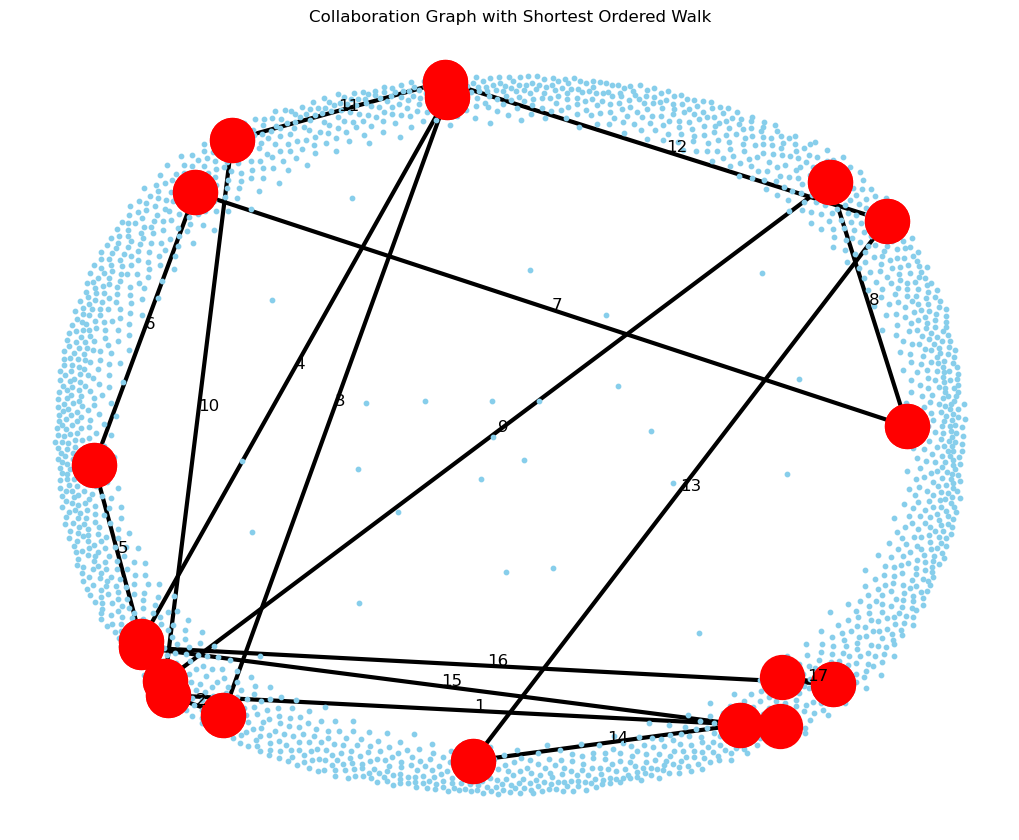

In [301]:
plot_shortest_walk(collaboration_subgraph, shortest_ordered_walk_result)

### Visualization 4 - Visualize the disconnected graph

Here we want to calculate the minimum number of edges to disconnect two specified nodes in a graph.
- This function visualizes the edges between two specified nodes in a graph.
- It takes three parameters: The graph, first node, second node (The nodes between which the edges will be visualized.)

Edge connectivity between 1445484688 and 1958887586: 11


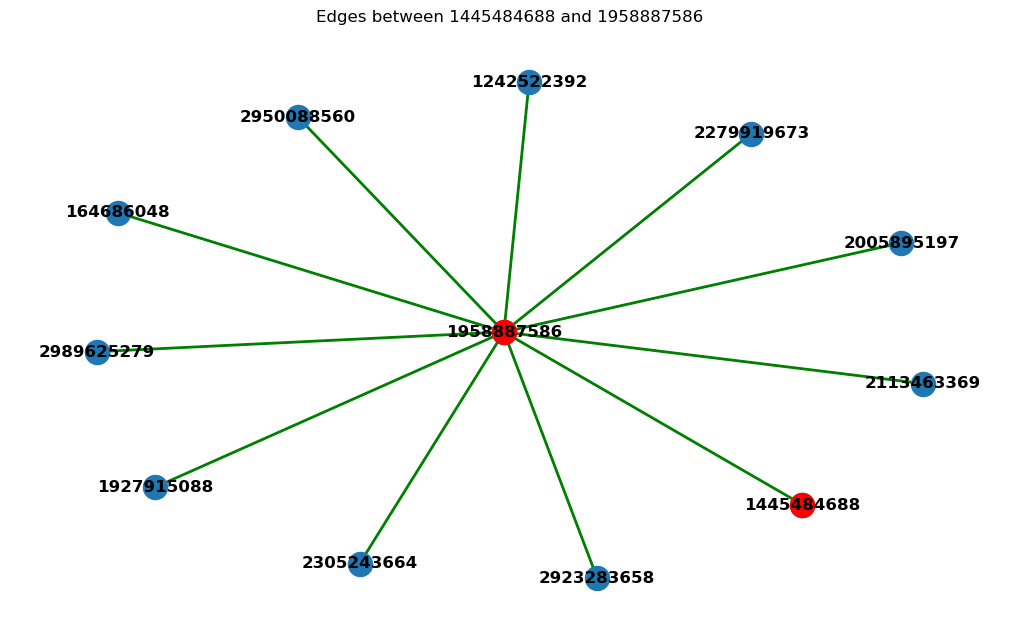

In [333]:
def plot_edges_between_nodes(graph, node_a, node_b):
    # Find the edges whose removal would disconnect the nodes
    edges = list(nx.minimum_edge_cut(graph, node_a, node_b))

    # Create a subgraph containing only the edges between node_a and node_b
    subgraph = graph.edge_subgraph(edges)

    # Visualize the subgraph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph)

    # Plot the subgraph with edges between the specified nodes highlighted
    nx.draw(subgraph, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, edge_color='g', width=2)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node_a, node_b], node_color='r', node_size=300)

    plt.title(f'Edges between {node_a} and {node_b}')
    plt.show()

# Nodes to visualize edges between
nodeA = '1445484688'
nodeB = '1958887586'

# Calculate the edge connectivity between author A and author B
edge_connectivity = min_edges_to_disconnect(collaboration_graph, nodeA, nodeB, authors_sequence)
print(f"Edge connectivity between {nodeA} and {nodeB}: {edge_connectivity}")

# Plot the graph showing edges between the specified nodes
plot_edges_between_nodes(collaboration_graph, nodeA, nodeB)


The edge connectivity of 11 between the nodes 1445484688 and 1958887586 suggests that there are 11 edges whose removal would disconnect these two nodes within the graph. This means that if you were to remove these 11 edges, the graph would be split into two disconnected subgraphs, preventing direct paths between nodes 1445484688 and 1958887586.

In [338]:
def remove_edges_and_plot_subset(subgraph, edges_to_remove, nodes_to_identify):
    
    # Remove the specified edges from the new graph
    subgraph.remove_edges_from(edges_to_remove)

    # Identify the two nodes
    node1, node2 = nodes_to_identify

    # Visualize the modified subgraph after removing edges and identifying nodes
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph)  # You can use different layouts as well

    # Plot the modified subgraph with removed edges
    nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color='skyblue')
    
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges_to_remove, edge_color='g', width=2)

    # Highlight the identified nodes
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node1, node2], node_color='r', node_size=300)

    plt.title('Subset of 30 Nodes: Modified Graph after Removing Links and Identifying Nodes')
    plt.show()

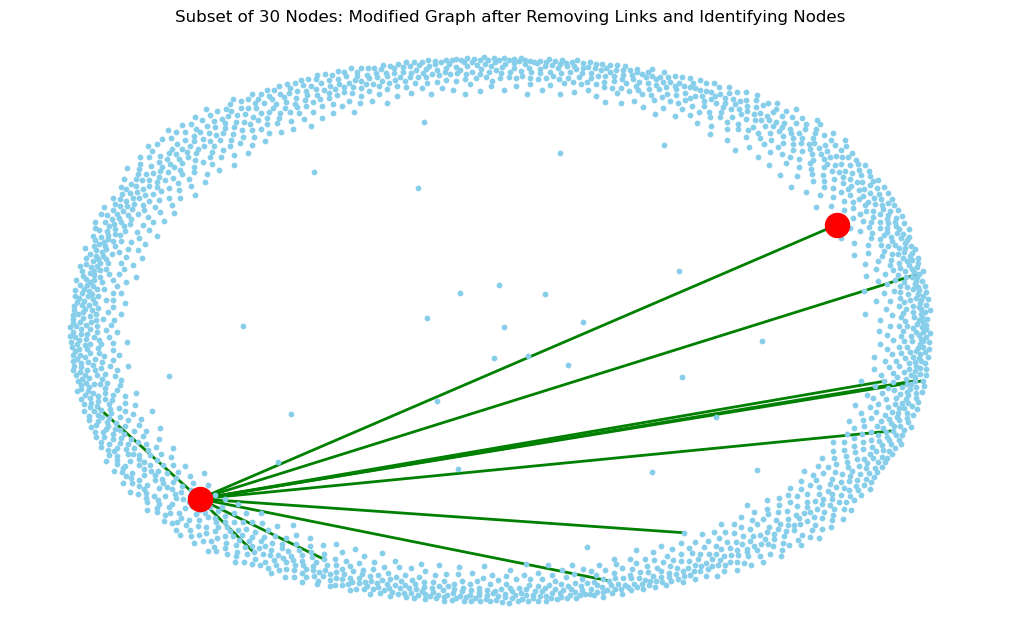

In [339]:
collaboration_subgraph = create_subgraph(collaboration_graph, 2000)

# Nodes to visualize edges between and identify
nodeA = '1445484688'
nodeB = '1958887586'

# Find the edges between the nodes
edges_to_remove = list(nx.minimum_edge_cut(collaboration_graph, nodeA, nodeB))

# Identify the two nodes
nodes_to_identify = [nodeA, nodeB]

# Remove identified edges and plot the modified graph with the subset of nodes
remove_edges_and_plot_subset(collaboration_subgraph, edges_to_remove, nodes_to_identify)

- The green edges should be removed, so these 2 graphs can be disconnected.
- Each red dot, representing our desired nodes. They all are connected to the blue nodes with green edges.
- The green lines are the edges from node A. However, Node B is also connected to the same blue nodes that node A is connected.
- So if we reomove the green lines, they will bee separated.

### Visualization 5 - Visualize the communities

- First, we need to achieve the communities

In [367]:
def extract_communities(graph, paper_1, paper_2):
    subset_nodes = list(graph.nodes())[:50]
    subgraph = nx.Graph()
    subgraph.add_nodes_from(subset_nodes)
    subgraph.add_edges_from(graph.subgraph(subset_nodes).edges())

    # Detect communities using Louvain method
    communities = list(nx.algorithms.community.greedy_modularity_communities(subgraph))

    # Find the minimum number of edges to remove for communities
    num_edges_to_remove = nx.algorithms.community.quality.modularity(subgraph, communities)

    # Check if Paper_1 and Paper_2 belong to the same community
    same_community = any([paper_1 in community and paper_2 in community for community in communities])

    return num_edges_to_remove, communities, same_community, subgraph


In [368]:
Paper_1 = '2298051088'
Paper_2 = '2596317628'

result = extract_communities(collaboration_graph, Paper_1, Paper_2)

result_edges, result_communities, papers_same_community, subgraph = result

print("Minimum number of edges to remove:", result_edges)
print("Communities:", result_communities)
print(f"Paper_1 and Paper_2 belong to the same community: {papers_same_community}")

Minimum number of edges to remove: 0.5840451989619377
Communities: [frozenset({'2316043942', '2027658599', '2559180283', '2146468246', '1932590790', '2084034853', '2007415138', '2096217197', '2153440608', '2232649233', '2874782720', '2105531243', '1904226804'}), frozenset({'2883906439', '2298051088', '1445484688', '2915467136', '1927915088', '2596317628', '2617619131', '2305243664', '2229427589'}), frozenset({'2150011549', '1208012566', '2120996014', '2175835430'}), frozenset({'2289542319', '2104401652', '2435751034'}), frozenset({'2977791946', '1975899429', '310679509'}), frozenset({'2102544963', '1990110535'}), frozenset({'2895256545', '2168176072'}), frozenset({'2022407533', '2134830209'}), frozenset({'185284988', '665787499'}), frozenset({'2057410742', '2170199860'}), frozenset({'2034063289', '2480517110'}), frozenset({'2033548732', '2140092859'}), frozenset({'2469405535', '2033942250'}), frozenset({'2097546270', '2055604604'})]
Paper_1 and Paper_2 belong to the same community: Tru

Here we plot the graph showing the communities in the network

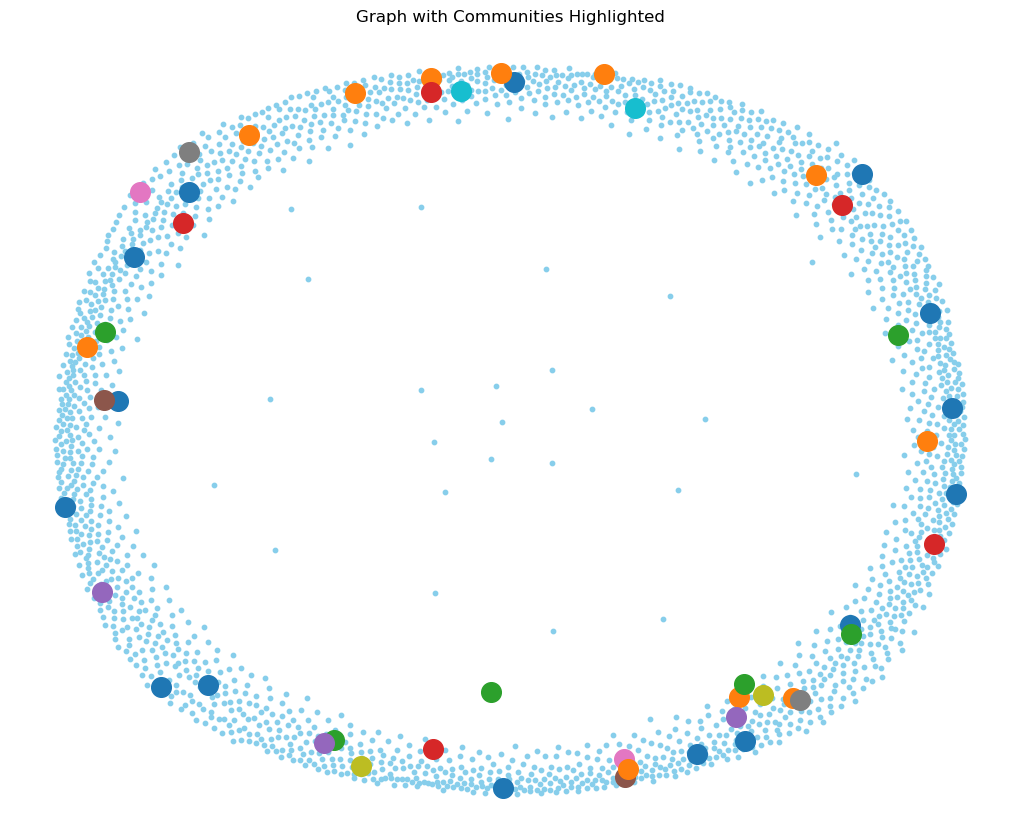

In [369]:
def community_graph(subgraph):
    # Plotting the graph with communities highlighted
    plt.figure(figsize=(10, 8))
    
    pos = nx.spring_layout(subgraph)
    
    # Draw nodes
    nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color='skyblue')

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos)
    
    # Highlight communities
    for i, community in enumerate(result_communities):
        nx.draw_networkx_nodes(subgraph, pos, nodelist=list(community), node_color=f"C{i}", node_size=200)
    
    plt.title('Graph with Communities Highlighted')
    plt.axis('off')
    plt.show()

collaboration_subgraph = create_subgraph(collaboration_graph, 2000)
community_graph(collaboration_subgraph)

Here we plot the final graph and identify the community/communities of Paper_1 and Paper_2

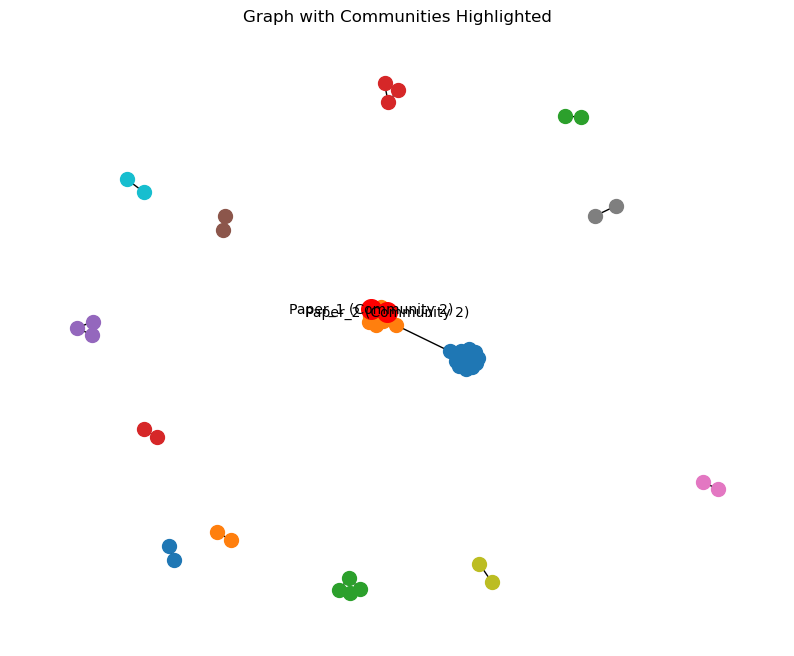

In [360]:
# Plotting the graph with communities highlighted
subset_nodes = list(collaboration_graph.nodes())[:50]
subgraph = nx.Graph()
subgraph.add_nodes_from(subset_nodes)
subgraph.add_edges_from(collaboration_graph.subgraph(subset_nodes).edges())

# Plotting the graph with communities highlighted
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(subgraph)  # You can choose different layout algorithms

# Draw edges
nx.draw_networkx_edges(subgraph, pos)

# Highlight communities
for i, community in enumerate(result_communities):
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(community), node_color=f"C{i}", node_size=100)

# Initialize empty labels dictionary for node labels
node_labels = {}

# Identify the communities of Paper_1 and Paper_2
for i, community in enumerate(result_communities):
    if Paper_1 in community:
        node_labels[Paper_1] = f"Paper_1 (Community {i+1})"
    if Paper_2 in community:
        node_labels[Paper_2] = f"Paper_2 (Community {i+1})"

# Draw nodes with labels
nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color='red', nodelist=node_labels.keys())
nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=10, font_color='black')

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()

# 5. Bouns - PageRank on MapReduce

for Sudenez: creating the csv file on your machine with this code (I'll take a while, it took me arount 10 min)

In [ ]:
# to be deleted after 
PAPERS = []

# if doesn't work, put here the right path file of the dataset you've downloaded from kaggle:
# with open("PUT HERE YOUR PATH", "rb") as f:

with open("dblp.v12.json", "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            # joining all authors in a list
            paper['authors'] = [auth for auth in authors]
        
        year = element.get('year')
        if year:
            paper['year']= year
        else:
            paper['year']= np.nan
        
        n_citation= element.get('n_citation')
        if n_citation:
             paper['n_citation']= element['n_citation']
        else:
            paper['n_citation']= 0
        
        doc_type= element.get('doc_type') 
        if doc_type:
            paper['doc_type']= element['doc_type']
        else:
            paper['doc_type']= np.nan      

        references= element.get('references')
        if references:
            paper['reference_count']= len(references)
            # joining all refs id in a `;` seperated string  
            paper['references']= ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count']= np.nan 
            paper['references']= np.nan
        
        doi = element.get('doi')
        if doi:
            paper['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper['doi']= np.nan               
        
        
        PAPERS.append(paper)

data = pd.DataFrame(PAPERS)
data.head()
data.to_csv("citations_network.csv", index=False)


In [17]:
# read the dataset
df = pd.read_csv('citations_network.csv')

exctract the first 1,000,000 papers with the highest number of citation they received

In [18]:
# Convert 'n_citation' column to numeric type if it contains mixed data types
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

# Sort the DataFrame by 'n_citation' column in descending order
df_sorted = df.sort_values(by='n_citation', ascending=False)

# Take the top 10,000 rows after sorting and reset the index
df_million = df_sorted.head(1000000).reset_index(drop=True)

# converting the authors' information from string to list
df_million['authors'] = df_million['authors'].apply(lambda row: ast.literal_eval(row))

now we can create our citation graph with 1,000,000 nodes

In [24]:
def citation_dict(row, d={}):
    if pd.notnull(row['references']):
        d[row['id']] = [int(cit) for cit in row['references'].split(';')]
    return d

# creating the graph

G = nx.DiGraph(name = 'Citation Graph')

# adding the nodes and the attributes (the columns of the dataset)
for i, pap in df_million.iterrows():
    node = pap['id']
    attributes = {}
    for el in list(df_million.columns)[1:]:
        attributes[el] = pap[el]
    G.add_node(node, **attributes)
 
# apply the function to each row in the DataFrame to save the citation's relationship in a dictionary
result_dict = {}
for idx, row in df_million.iterrows():
    result_dict = citation_dict(row, result_dict)

for start in result_dict.keys():
    for end in result_dict[start]:
        G.add_edge(start, end)
    
# the graph is created and it's called G
print(f'Number of nodes in the citation Graph considering the first million papers: {len(G.nodes())}')

1691367


now the graph is created, ad we can start working with it

# 4. CLQ

Referring to the Citation graph:
1. Is there any node that acts as an important "connector" between the different parts of the graph?\
   this is a task of community detection on the graph, so by computing the betweenes centrality of each node of the graph, I can extract the node that acts as an important connector
